In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from sklearn.metrics import mean_squared_error

import pickle
import time

from IPython.display import clear_output

from utils import get_views_coord
from utils import test_val_train

Todo:

1) Make sure that predictions can be merged back to data frame 
    -> but is that even relevant before we get to the predictions? Where it is arguebly a bit easier...

2) Change it so you predict for all time lines (at least C>0) no matter what you train on.   
3) Move functions to Util.
4) Make final classifier
4) Make ready to run eksperiments on comuterome.   

Bonus) Also don't forget you only do sb right now. Would be nice to also have ns and os.

Q's) 
- why don't they use 1989 for train?
- Don't they say 36 months? But there are only 36 in train and val? Is that because they say 36 months into the furture? 


In [2]:
start_time = time.time()

In [3]:
df = get_views_coord()

In [4]:
train_id, val_id = test_val_train(df)
#train_id, test_id = test_val_train(df, test_time = True)

Train from 1/1990 trough 12/2011 (264)
Val from 1/2012 trough 12/2014 (36)
Test time from 1/2015 trough 12/2017 (36)
(Test=False, so test set not outputted)



In [8]:
def sample_conflict_timeline(df = df, train_id = train_id, test_id = val_id, C=5, N=3, demean = False, seed = 42, get_index = False):

    """ This function samples N time-lines contining c>=C conflicts. 
    If N == None, it gets all time-lines with c>C conflicts.
    As default it will try to get the val_id. Error will come if it does not exits"""

    # sort the df - just in case
    df_sorted = df.sort_values('month_id')

    # groupby gids and get total events
    df_sb_total_events = df.groupby(['pg_id']).sum()['ged_dummy_sb'].reset_index().rename(columns = {'ged_dummy_sb':'ged_total_events_sb'})
    
    if N == None:
        sample_gids = df_sb_total_events[df_sb_total_events['ged_total_events_sb'] >= C]['pg_id'].values
        N = len(sample_gids)

    else:
        # sample one gid from all gids from timeline with c>C events
        sample_gids = df_sb_total_events[df_sb_total_events['ged_total_events_sb'] > C]['pg_id'].sample(N, random_state = seed).values

    train_mask = df_sorted['pg_id'].isin(sample_gids) & df_sorted['id'].isin(train_id) 
    test_mask = df_sorted['pg_id'].isin(sample_gids) & df_sorted['id'].isin(test_id)
    
    y = np.log(df_sorted[train_mask]['ged_best_sb'] +1).values.reshape(-1,N)
    X = df_sorted[train_mask]['month_id'].values.reshape(-1,N)

    y_test = np.log(df_sorted[test_mask]['ged_best_sb'] +1).values.reshape(-1,N)
    X_test = df_sorted[test_mask]['month_id'].values.reshape(-1,N)

    if demean == True:

        y = y - y.mean(axis = 0) # you can't demean testset right?

    print(f'\nX: {X.shape}, y: {y.shape} \nX (val/test): {X_test.shape}, y (val/test): {y_test.shape} \n')

    if get_index == False:
        return(X, y, X_test, y_test)


    if get_index == True:

        idx = df_sorted[train_mask]['id'].values.reshape(-1,N)
        idx_test = df_sorted[test_mask]['id'].values.reshape(-1,N)

        return(X, y, X_test, y_test, idx, idx_test)
    

In [9]:
X, y, X_test, y_test, idx, idx_test = sample_conflict_timeline(C = 100, N = None, get_index= True)

# You can reattach you id thus
#df2 = pd.DataFrame({'id' : idx.reshape(-1,), 'X' : X.reshape(-1,), 'y' : y.reshape(-1,)}) 
#df3 = pd.DataFrame({'id' : idx_test.reshape(-1,), 'X' : X_test.reshape(-1,), 'y' : y_test.reshape(-1,)}


X: (264, 6), y: (264, 6) 
X (val/test): (36, 6), y (val/test): (36, 6) 



In [12]:
) 

# seems to work to get back to id

In [ ]:
#X, y = sample_conflict_timeline(C = 100, N = None)
# X, y, idx = sample_conflict_timeline(C = 16, N = None, get_index= True)
#df2 = pd.DataFrame({'id' : idx.reshape(-1,), 'X' : X.reshape(-1,), 'y' : y.reshape(-1,)}) # seems to work to get back to id

So, you wnat to make it as a function that can by iterated over, shitching C and shortterm cov - and maybe even priors.
It needs to give out mse and save it. You also need to be able to survey/plot the models you afterwards find most interesting.

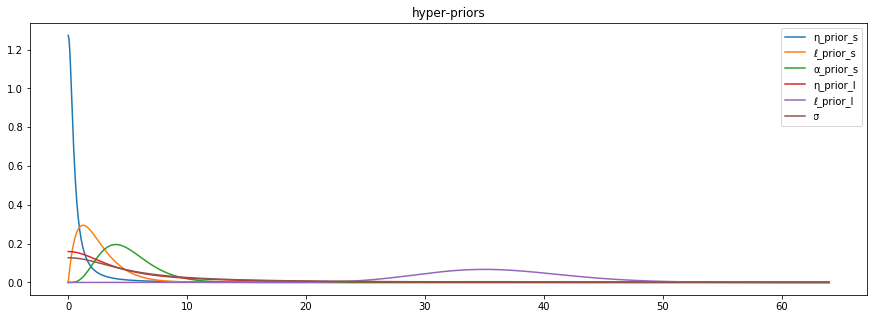

In [6]:
def get_hyper_priors(plot = True):
    
    #hyper_priors_dict
    hps = {}

    # short term priors
    hps['η_beta_s'] = 0.5
    hps['ℓ_beta_s'] = 0.8
    hps['ℓ_alpha_s'] = 2

    hps['α_alpha_s'] = 5 # for Rational Quadratic Kernel. Ignore for Quad or Matern
    hps['α_beta_s'] = 1 # for Rational Quadratic Kernel. Ignore for Quad or Matern

    # long term priors
    hps['η_beta_l'] = 4
    hps['ℓ_beta_l'] = 1
    hps['ℓ_alpha_l'] = 36

    # noise prior
    hps['σ_beta'] = 5

    if plot == True:

        # plot:
        grid = np.linspace(0,64,1000)
            
        priors = [
            ('η_prior_s', pm.HalfCauchy.dist(beta=hps['η_beta_s'])),
            ('ℓ_prior_s', pm.Gamma.dist(alpha=hps['ℓ_alpha_s'] , beta=hps['ℓ_beta_s'])),
            ('α_prior_s', pm.Gamma.dist(alpha=hps['α_alpha_s'], beta= hps['α_beta_s'])),
            ('η_prior_l', pm.HalfCauchy.dist(beta=hps['η_beta_l'])),
            ('ℓ_prior_l', pm.Gamma.dist(alpha=hps['ℓ_alpha_l'] , beta=hps['ℓ_beta_l'])),
            ('σ', pm.HalfCauchy.dist(beta=hps['σ_beta']))]

        plt.figure(figsize= [15,5])
        plt.title('hyper-priors')

        for i, prior in enumerate(priors):
            plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

        plt.legend()
        plt.show()

    return(hps)

hyper_priors_dict = get_hyper_priors(plot = True)

In [7]:
# 43.3 minutes with 148 time-lines
C = 100 # -> 6 obs
# C = 64 # -> 12 obs
# C = 40 # -> 38 obs
# C = 32 # -> 60 obs
# C = 24 # -> 87 obs
# C = 16 # -> 158 obs

N=None
seed = 42
dem = False

hps = get_hyper_priors(plot = False)

with pm.Model() as model:

    # short term trend/irregularities ---------------------------------
    ℓ_s = pm.Gamma("ℓ_s", alpha=hps['ℓ_alpha_s'] , beta=hps['ℓ_beta_s'])
    η_s = pm.HalfCauchy("η_s", beta=hps['η_beta_s'])
    α_s = pm.Gamma("α_s", alpha=hps['α_alpha_s'], beta=hps['α_beta_s']) #for Rational Quadratic Kernel. Ignore for Quad or Matern 

    # mean and kernal for short term trend
    mean_s =  pm.gp.mean.Zero()
    #cov_s = η_s ** 2 * pm.gp.cov.RatQuad(1, ℓ_s, α_s) # this seems to help alot when you split the trends below
    cov_s = η_s ** 2 * pm.gp.cov.ExpQuad(1, ℓ_s) # this seems to help alot when you split the trends below
    # so this needs to be some thng you can vary over in a loop

    # GP short term trend 
    gp_s = pm.gp.Marginal(mean_func = mean_s, cov_func=cov_s)


    # long term trend -------------------------------------------------
    ℓ_l = pm.Gamma("ℓ_l", alpha=hps['ℓ_alpha_l'] , beta=hps['ℓ_beta_l'])
    η_l = pm.HalfCauchy("η_l", beta=hps['η_beta_l'])
    
    # mean and kernal for long term trend
    mean_l =  pm.gp.mean.Zero()
    cov_l = η_l **2 * pm.gp.cov.ExpQuad(1, ℓ_l) # Cov func.
    
    # GP short term trend 
    gp_l = pm.gp.Marginal(mean_func = mean_l, cov_func=cov_l)


    # noise (constant "white noise") -----------------------------------
    σ = pm.HalfCauchy("σ", beta=hps['σ_beta'])


    # sample and split X,y ---------------------------------------------  
    X, y = sample_conflict_timeline(df, C = C, N = N, demean = dem, seed = seed)
    X_val = X[start[1]:end[1],:] # val 2012- 2015
    y_val = y[start[1]:end[1],:] # val 2012- 2015
    X = X[start[0]:end[0],:] # train 1990-2011
    y = y[start[0]:end[0],:] # train 1990-2011

    # Full GP ----------------------------------------------------------
    gp = gp_s + gp_l

    # sample:
    for i in range(y.shape[1]):
        
        print(f'Time-line {i+1}/{y.shape[1]} in the works...') # why does it not print?
        clear_output(wait=True)

        y_ = gp.marginal_likelihood(f'y_{i}', X=X[:,i][:,None], y=y[:,i], noise= σ)
        
    
    mp = pm.find_MAP()


In [8]:
pd.DataFrame(
    {
        "Parameter": ["ℓ_s", "η_s", "α_s", "ℓ_l", "η_l", "σ"],
        "Value at MAP": [float(mp["ℓ_s"]), float(mp["η_s"]), float(mp["α_s"]), float(mp["ℓ_l"]), float(mp["η_l"]), float(mp["σ"])],
    }
)

,Parameter,Value at MAP
0,ℓ_s,2.729681
1,η_s,0.528467
2,α_s,4.000397
3,ℓ_l,36.046269
4,η_l,1.303920
5,σ,0.916321


In [9]:
end_time = time.time()
run_time = end_time - start_time

string = f'Run for {run_time/60:.3} minutes with {y.shape[1]} time-lines'
print(string)

Run for 1.53 minutes with 6 time-lines


In [10]:
# actually tese functions should come before (or in a util script so you can just use them in the end of the gp-loop)
# you should predict on all C>1 obs disregarding what C you use for training

In [77]:
def predict(forecast_months = 36, X = X, y = y, gp_s = gp_s, gp_l = gp_l, gp = gp, σ = σ, demean = dem): 
    # but don't you only have 35 months in the val set?

    # sample all conflicts (eventually all )

    # sample and split X,y ---------------------------------------------  
    X, y, idx = sample_conflict_timeline(df, C = 100, N = None, demean = dem, get_index = True)
    
    # you need some option to change this for test time
    X_val = X[start[1]:end[1],:] # val 2012- 2015
    y_val = y[start[1]:end[1],:] # val 2012- 2015
    
    X = X[start[0]:end[0],:] # train 1990-2011
    y = y[start[0]:end[0],:] # train 1990-2011

    idx = idx[start[0]:end[1],:] # both train and val 1990-2015
    
    # start timer
    start_time = time.time()

    # dict
    preds = {}

    preds['mu_list'] = []
    preds['var_list'] = []
    preds['mu_s_list'] = []
    preds['var_s_list'] = []
    preds['var_l_list'] = []
    preds['mu_l_list'] = []

    preds['id'] = []

    # new values from X.min() to X.max() + forecast_months to forecast into
    # X_new = np.linspace(X.min(), X.max() + forecast_months, (X.max() + forecast_months +1))[:, None]
    X_new = np.arange(X.min(), X.max() + forecast_months + 1, 1)[:, None]

    # pred loop
    for i in range(y.shape[1]):

        mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, diag=True)
        preds['mu_list'].append(mu)
        preds['var_list'].append(var)

        mu_s, var_s = gp_s.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, diag=True)
        preds['mu_s_list'].append(mu_s)
        preds['var_s_list'].append(var_s)

        mu_l, var_l = gp_l.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, diag=True)
        preds['mu_l_list'].append(mu_l)
        preds['var_l_list'].append(var_l)

        preds['id'].append(idx[:,i])

        print(f'Time-line {i+1}/{y.shape[1]} predicted....')
        clear_output(wait=True)

    # end timer
    end_time = time.time()
    run_time = end_time - start_time

    string = f'Run for {run_time/60:.3} minutes with {y.shape[1]} time-lines'
    print(string)


    # new thing
    # df_pred = pd.DataFrame({
    #     'id' : idx.reshape(-1,),
    #     'mu' : np.array(preds['mu_list']).reshape(-1,), 
    #     'var' : np.array(preds['var_list']).reshape(-1,),
    #     'mu_s' : np.array(preds['mu_s_list']).reshape(-1,),
    #     'var_s' : np.array(preds['var_s_list']).reshape(-1,),
    #     'mu_l' : np.array(preds['mu_l_list']).reshape(-1,),
    #     'var_s' : np.array(preds['var_l_list']).reshape(-1,)}) # seems to work to get back to id


    return(preds, X_new) #, idx, df_pred)

In [78]:
# preds, X_new, idx, df_pred = predict()
preds, X_new = predict()

Run for 0.957 minutes with 6 time-lines


In [64]:
# so get the relevant ids from df and merge with df_pred. then plot to se that it fits.. 

# df_merged = pd.merge(df_pred, df[['id', 'pg_id', 'month_id', 'ged_best_sb']], how = 'left', on = 'id')
# df_merged['log_best_sd'] = np.log(df_merged['ged_best_sb'] + 1)
# df_merged

In [124]:
df[df['id'].isin(preds['id'][i])]['month_id'].iloc[start[1]:end[1]].shape

(23,)

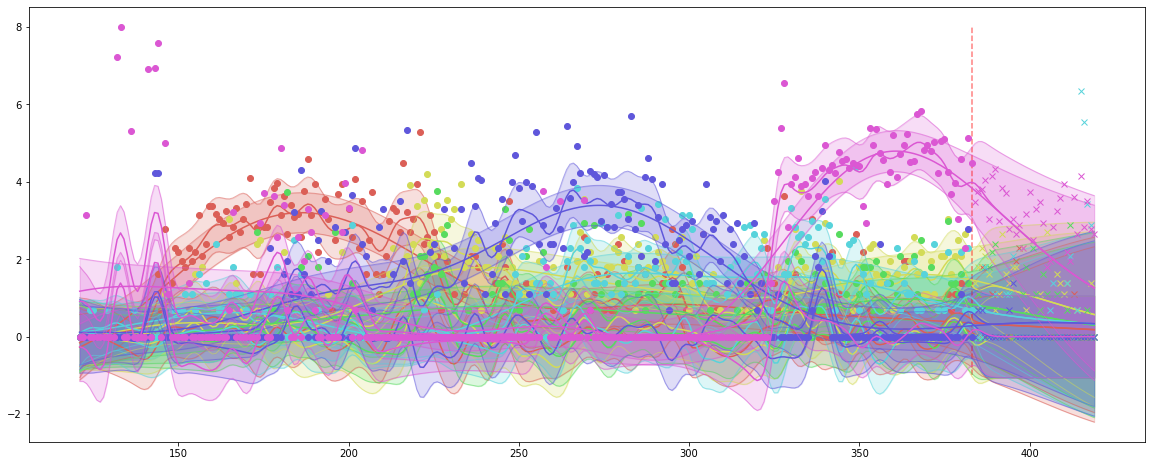

In [133]:
colors = sns.color_palette("hls", len(preds['id']))
fig = plt.figure(figsize=(20, 8))

forcasting_months = 36

for i  in range(len(preds['id'])):

    idx = preds['id'][i]
    mu = np.array(preds['mu_list'][i])
    mu_s = np.array(preds['mu_s_list'][i])
    mu_l = np.array(preds['mu_l_list'][i])

    sd = np.sqrt(np.array(preds['var_list'][i]))
    sd_s = np.sqrt(np.array(preds['var_s_list'][i]))
    sd_l = np.sqrt(np.array(preds['var_l_list'][i]))


    X = df[df['id'].isin(preds['id'][i])]['month_id']
    y = np.log(df[df['id'].isin(preds['id'][i])]['ged_best_sb'] + 1)

    plt.plot(X.iloc[:-forcasting_months], y.iloc[:-forcasting_months], 'o', color = colors[i])
    
    plt.plot(X.iloc[-forcasting_months:], y.iloc[-forcasting_months:], 'x', color = colors[i])
    # train # but why does it not work with end and start... 
    # test # Bc you only get the ids that you have. 
    #So starting at 12 fucks stuff up 

    plt.plot(X, mu, '-', color = colors[i])

    plt.plot(X, mu_s, '-', color = colors[i])
    plt.plot(X, mu_l, '-', color = colors[i])

    #if full_sd == True:
    plt.plot(X, mu + 2 * sd, "-", lw=1, color=colors[i], alpha=0.5)
    plt.plot(X, mu - 2 * sd, "-", lw=1, color=colors[i], alpha=0.5)
    plt.fill_between(X, mu - 2 * sd, mu + 2 * sd, color=colors[i], alpha=0.2)

    #if short_sd == True:
    plt.plot(X, mu_s + 2 * sd_s, "-", lw=1, color=colors[i], alpha=0.5)
    plt.plot(X, mu_s - 2 * sd_s, "-", lw=1, color=colors[i], alpha=0.5)
    plt.fill_between(X, mu_s - 2 * sd_s, mu_s + 2 * sd_s, color=colors[i], alpha=0.2)

    #if long_sd == True:
    plt.plot(X, mu_l + 2 * sd_l, "-", lw=1, color=colors[i], alpha=0.5)
    plt.plot(X, mu_l - 2 * sd_l, "-", lw=1, color=colors[i], alpha=0.5)
    plt.fill_between(X, mu_l - 2 * sd_l, mu_l + 2 * sd_l, color=colors[i], alpha=0.2)

# plot train/val line
plt.vlines(X.max()-forcasting_months,y.min()-1,y.max(), linestyles='dashed', color = 'red', alpha = 0.5)

plt.show()

In [135]:
len(preds['id'])

6

In [142]:
X_new.shape

(299, 1)

# old plot..

In [58]:
def plot_predictions(mu_list, var_list, X = X, X_val = X_val, X_new = X_new, y = y, y_val = y_val, plot_sd = False): # the vals are made in the gp loop...

    mu = np.array(mu_list)
    sd = np.sqrt(np.array(var_list))

    #colors = sns.color_palette("hls", y.shape[1])
    colors = sns.color_palette("hls", 6)


    fig = plt.figure(figsize=(20, 8))

    for i in range(y.shape[1]):

        # plot predicted function
        plt.plot(X_new, mu[i,:], "-", lw=2, color=colors[i])

        if plot_sd == True:
            plt.plot(X_new, mu[i,:] + 2 * sd[i,:], "-", lw=1, color=colors[i], alpha=0.5)
            plt.plot(X_new, mu[i,:] - 2 * sd[i,:], "-", lw=1, color=colors[i], alpha=0.5)
            plt.fill_between(X_new.flatten(), mu[i,:] - 2 * sd[i,:], mu[i,:] + 2 * sd[i,:], color=colors[i], alpha=0.2)

        # plot original data: train and val
        plt.plot(X[:,i], y[:,i], "o", ms=3, color=colors[i], alpha=1.0)
        plt.plot(X_val[:,i], y_val[:,i], "x", ms=6, color=colors[i], alpha=1.0)

    # plot train/val line
    plt.vlines(X.max(),y.min()-1,y.max(), linestyles='dashed', color = 'red', alpha = 0.5)

    plt.title(f"predictive mean and 2σ interval")
    plt.show()


In [59]:
plot_predictions(preds['mu_list'], preds['var_list'], plot_sd = False)
plot_predictions(preds['mu_s_list'], preds['var_s_list'], plot_sd = False)
plot_predictions(preds['mu_l_list'], preds['var_l_list'], plot_sd = False)

IndexError: tuple index out of range

In [15]:
def get_mse(mu_list, y_val = y_val):

    mse_list = []
    mu = np.array(mu_list)

    for i in range(y_val.shape[1]):

        true = y_val[:,i]
        pred = np.array(mu_list)[i,-y_val.shape[0]:] #takes the last predictions corrospoding to the val set
        mse_list.append(mean_squared_error(true, pred))

    mse_mean = np.array(mse_list).mean()
    mse_std = np.array(mse_list).std()

    return(mse_list, mse_mean, mse_std)

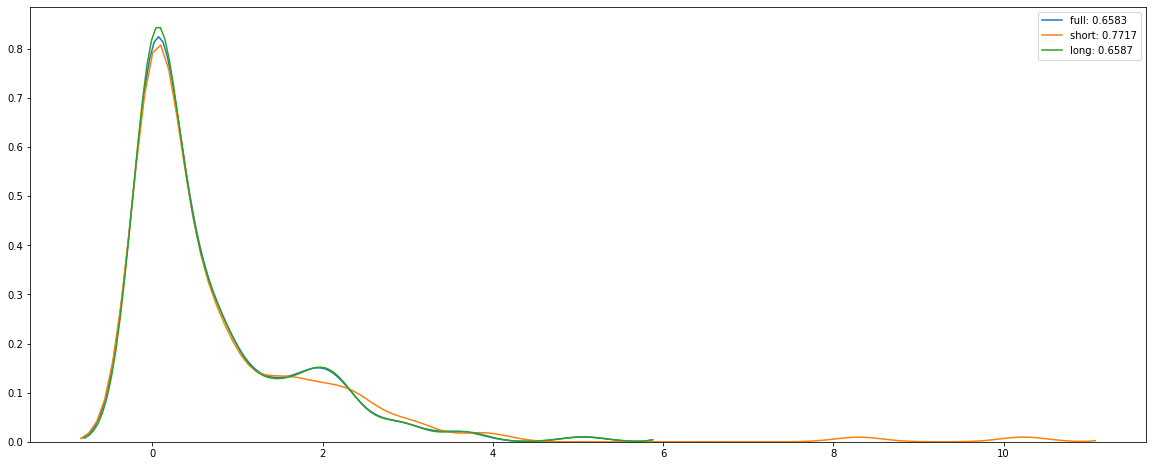

In [16]:
# make this a funciton adn get it to util.

mse, mse_mean, mse_std = get_mse(preds['mu_list'])
mse_s, mse_mean_s, mse_std_s = get_mse(preds['mu_s_list'])
mse_l, mse_mean_l, mse_std_l = get_mse(preds['mu_l_list'])

fig = plt.figure(figsize=(20, 8))

sns.kdeplot(mse, label = f'full: {mse_mean:.4}' )
sns.kdeplot(mse_s, label = f'short: {mse_mean_s:.4}')
sns.kdeplot(mse_l, label = f'long: {mse_mean_l:.4}')

plt.show()

In [17]:
# demeaning is not dead yet... You should already now try out with a simple ensample classifier or some thing in the end - train as you fight.. 

# And full is doing quite well, when you start to include more time lines (but in this case, it is also becouae it did not split short and long corectly...)..

# importantly you also need to predict time lines that where not even in the trainset...

# Squad Ex kernel for short term is fine with more observaitons (C = 32 -> N = 55  )
# Also Squad Ex kernel for short term is fine with more observaitons (C = 24 -> N = 85  )

# the fact that lenghtscale_short changes so much as a funciton of C is a good justification, but then it also needs to work.